# Quantum Gate calibration using Model Free Reinforcement Learning

We extend the state preparation scheme to a gate calibration scheme by providing multiple input states to the target.

In [340]:
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)
from quantumenvironment import QuantumEnvironment
from helper_functions import select_optimizer, generate_model
from qconfig import QiskitConfig
# Qiskit imports for building RL environment (circuit level)
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.extensions import CXGate, XGate
from qiskit.opflow import Zero, One, Plus, Minus, H, I, X, CX, S, Z
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

# Tensorflow imports for building RL agent and framework
import tensorflow as tf
from tensorflow_probability.python.distributions import MultivariateNormalDiag

# Additional imports
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

In [341]:
# Ansatz function, could be at pulse level or circuit level
def apply_parametrized_circuit(qc: QuantumCircuit):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    :param qc: Quantum Circuit instance to add the gates on
    :return:
    """
    # qc.num_qubits
    global n_actions
    params = ParameterVector('theta', n_actions)
    qc.u(2 * np.pi * params[0], 2 * np.pi * params[1], 2 * np.pi * params[2], 0)
    qc.u(2 * np.pi * params[3], 2 * np.pi * params[4], 2 * np.pi * params[5], 1)
    qc.rzx(2 * np.pi * params[6], 0, 1)

# Defining the QuantumEnvironment

Below, we set the RL environment parameters, that is how we describe our quantum system. Below, we can choose to go through the use of Qiskit Runtime, or to speed things up by using the local CPU and a state-vector simulator to get measurement outcomes based on the ansatz circuit defined above. The Environment is defined as a class object called QuantumEnvironment.

## Generic information characterizing the quantum system

The algorithm is built upon Qiskit modules. To specify how to address our quantum system of interest, we therefore adopt the IBM approach to define a quantum backend, on which qubits are defined and can be accessed via control actions and measurements.

The cell below specifies:
- ```qubit_tgt_register```: List of qubit indices which are specifically addressed by controls , namely the ones for which we intend to calibrate a gate upon or steer them in a specific quantum state. Note that this list could include less qubits than the total number of qubits, which can be useful when one wants to take into account crosstalk effects emerging from nearest-neigbor coupling.
- ```sampling_Paulis```: number of Pauli observables  to be sampled from the system: the algorithm relies on the ability to process measurement outcomes to estimate the expectation value of different Pauli operators. The more observables we provide for sampling, the more properties we are able to deduce with accuracy about the actual state that was created when applying our custom controls. For a single qubit, the possible Pauli operators are $\sigma_0=I$, $\sigma_x=X$, $\sigma_y=Y$, $\sigma_z=Z$. For a general multiqubit system, the Pauli observables are tensor products of those single qubit Pauli operators. The algorithm will automatically estimate which observables are the most relevant to sample based on the provided target. The probability distribution from which those observables are sampled is derived from the Direct Fidelity Estimation (equation 3, https://link.aps.org/doi/10.1103/PhysRevLett.106.230501) algorithm. 
- ```N_shots```: Indicates how many measurements shall be done for each provided circuit (that is a specific combination of an action vector and a Pauli observable to be sampled)
- The dimension of the action vector: Indicates the number of pulse/circuit parameters that characterize our parametrized quantum circuit.
- ```estimator_options```: Options of the Qiskit Estimator primitive. The Estimator is the Qiskit module enabling an easy computation of Pauli expectation values. One can set options to make this process more reliable (typically by doing some error mitigation techniques in post-processing). Works only with Runtime Backend at the moment
- ```abstraction_level``` chosen to encode our quantum circuit. One can choose here to stick to the usual circuit model of quantum computing, by using the ```QuantumCircuit``` objects from Qiskit and therefore set the ```abstraction_level``` to ```"circuit"```. However, depending on the task at hand, one can also prefer to use a pulse description of all the operations in our circuit. This is possible by using resources of another module of Qiskit called Qiskit Dynamics. In this case, one should define the ansatz circuit above in a pulse level fashion, and the simulation done at the Hamiltonian level, and not only via statevector calculations. In this notebook we set the ```abstraction_level``` to ```"circuit"```. Another notebook at the pulse level is available in the repo.

In [342]:
qubit_tgt_register = [0, 1]  # Choose which qubits of the QPU you want to address 
sampling_Paulis = 100
N_shots = 1  # Number of shots for sampling the quantum computer for each action vector
n_actions = 7  # Choose how many control parameters in pulse/circuit parametrization
seed = 4000
estimator_options = {'seed_simulator': seed,'resilience_level': 0}

Choose below which IBM Backend to use. As we are dealing with circuit level implementation, we can look for a backend supporting Qiskit Runtime (could be a cloud simulator, or real backend) or simply set backend to None and rely on the Estimator primitive based on statevector simulation. In either case, we need access to one Estimator primitive to run the algorithm, as the feedback from the measurement outcomes is done by calculating Pauli expectation values.

## 1. Setting up a Quantum Backend

### Real backend initialization

Uncomment the cell below to declare a Qiskit Runtime backend. You need an internet connection and an IBM Id account to access this.

In [343]:
"""
Real backend initialization:
Run this cell only if intending to use a real backend,
where Qiskit Runtime is enabled
"""
backend_name = 'ibm_perth'

#service = QiskitRuntimeService(channel='ibm_quantum')
#runtime_backend = service.get_backend(backend_name)
#estimator_options = {'resilience_level': 0}


### Simulation backend initialization
If you want to run the algorithm over a simulation, you can use Qiskit BaseEstimator, which does not need any real backend and relies on statevector simulation.

Note that you could also define a custom Aer noise model and use an Aer version of the Estimator primitive. This feature will become available soon.


In [344]:
"""
If using Qiskit native Estimator primitive
(statevector simulation)
"""
no_backend = None

### Choose backend and define Qiskit config dictionary
Below, set the Backend that you would like to run among the above defined backend.
Then define the config gathering all the components enabling the definition of the ```QuantumEnvironment```.



In [345]:
backend = no_backend


In [346]:
# Wrap all info in one dict Qiskit_setup
Qiskit_setup = QiskitConfig(parametrized_circuit=apply_parametrized_circuit, backend=backend,
                            estimator_options=estimator_options)

## 2. Define quantum target: State preparation or Gate calibration

The target of our optimal control task can be of two different types:
1.  An arbitrary quantum state to prepare with high accuracy
2. A Quantum Gate to be calibrated in a noise-robust manner

Both targets are dictionaries that are identified with a key stating their ```target_type```, which can be either ```"state"``` or ```"gate"```.

For a gate target $G$, one can add the target quantum gate with a ```"gate"``` argument specifying a specific instance of a Qiskit ```Gate``` object. Here, we settle for calibrating a ```CXGate()```.
Moreover, a gate calibration requires a set of input states $\{|s_i\rangle \}$ to be provided, such that the agent can try to set the actions such that the fidelity between the anticipated ideal target state (calculated as  $G|s_i\rangle$) and the output state are simultaneously maximized. To ensure a correlation between the average reward computed from the measurement outcomes and the average gate fidelity, the provided set of input states must be tomographically complete.

For a state target, one can provide, similarly to an input state, an ideal circuit to prepare it (```"circuit": QuantumCircuit```, or a density matrix (key ```"dm": DensityMatrix```).

Another important key that should figure in the dictionary is the ```"register"``` indicating the qubits indices that should be addressed by this target, i.e. upon which qubits should the target be engineered.


In [347]:
# Target gate: CNOT gate

circuit_Plus_i = S @ H
circuit_Minus_i = S @ H @ X
cnot_target = {
    "target_type": "gate",
    "gate": CXGate("CNOT"),
    "register": qubit_tgt_register
}


In [348]:
target = cnot_target

## 3. Declare QuantumEnvironment object
Running the box below declares the QuantumEnvironment instance.


In [349]:
# Define quantum environment

q_env = QuantumEnvironment(target=target, abstraction_level="circuit",
                           Qiskit_config=Qiskit_setup,
                           sampling_Pauli_space=sampling_Paulis, n_shots=N_shots, c_factor=0.25)

## Defining the Neural Network for RL

In [350]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, input_shape, hidden_units, n_actions, actor_critic_together=True, hidden_units_critic=None):
        super(NeuralNetwork, self).__init__()
        
        # Actor Network
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_shape[0], hidden_units[0]))
        for i in range(1, len(hidden_units)):
            self.layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
        self.mean_vec = nn.Linear(hidden_units[-1], n_actions)
        self.sigma_vec = nn.Linear(hidden_units[-1], n_actions)
        
        # Critic Network (if needed)
        if actor_critic_together:
            self.critic_output = nn.Linear(hidden_units[-1], 1)
        else:
            self.critic_layers = nn.ModuleList()
            self.critic_layers.append(nn.Linear(input_shape[0], hidden_units_critic[0]))
            for i in range(1, len(hidden_units_critic)):
                self.critic_layers.append(nn.Linear(hidden_units_critic[i-1], hidden_units_critic[i]))
            self.critic_output = nn.Linear(hidden_units_critic[-1], 1)
        
    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        mean = torch.tanh(self.mean_vec(x))
        sigma = F.softplus(self.sigma_vec(x))
        
        if hasattr(self, 'critic_layers'):
            critic_input = x
            for layer in self.critic_layers:
                critic_input = F.relu(layer(critic_input))
            critic_out = self.critic_output(critic_input)
        else:
            critic_out = self.critic_output(x)
        
        return mean, sigma, critic_out

# Defining the RL agent: PPO

In [351]:
def select_optimizer(params, lr, optimizer="Adam", grad_clip=None, concurrent_optimization=True, lr2=None):
    if optimizer == "Adam":
        opt = torch.optim.Adam(params, lr=lr)
    elif optimizer == "SGD":
        opt = torch.optim.SGD(params, lr=lr)
    
    # Handle grad_clip if needed (example for Adam optimizer)
    if grad_clip:
        for group in opt.param_groups:
            for param in group['params']:
                param.grad = param.grad.clamp(-grad_clip, grad_clip)
    
    return opt

In [352]:
"""
-----------------------------------------------------------------------------------------------------
Hyperparameters for RL agent
-----------------------------------------------------------------------------------------------------
"""
%time

n_epochs = 1000  # Number of epochs
batchsize = 300  # Batch size (iterate over a bunch of actions per policy to estimate expected return)
opti = "Adam"  # Optimizer choice
eta = 0.0018  # Learning rate for policy update step
eta_2 = None  # Learning rate for critic (value function) update step

use_PPO = True
epsilon = 0.1  # Parameter for clipping value (PPO)
grad_clip = 0.02
critic_loss_coeff = 0.5

# optimizer = select_optimizer(lr=eta, optimizer=opti, grad_clip=grad_clip, concurrent_optimization=True, lr2=eta_2)

sigma_eps = 1e-6 # for numerical stability

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.01 µs


In [353]:
from torchsummary import summary
"""
-----------------------------------------------------------------------------------------------------
Policy parameters
-----------------------------------------------------------------------------------------------------
"""
n_qubits = 2  # Number of qubits in the system
N_in = n_qubits + 1  # One input for each measured qubit state (0 or 1 input for each neuron)
input_shape = (N_in,) 
hidden_units = [20, 20, 30]  # List containing number of units in each hidden layer

network = NeuralNetwork((N_in,), hidden_units, n_actions, actor_critic_together=True)
optimizer = select_optimizer(network.parameters(), lr=eta, optimizer=opti)
init_msmt = np.zeros((1, N_in))  # Here no feedback involved, so measurement sequence is always the same

summary(network, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]              80
            Linear-2                   [-1, 20]             420
            Linear-3                   [-1, 30]             630
            Linear-4                    [-1, 7]             217
            Linear-5                    [-1, 7]             217
            Linear-6                    [-1, 1]              31
Total params: 1,595
Trainable params: 1,595
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [354]:
# Plotting tools
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
avg_return = np.zeros(n_epochs)
fidelities = np.zeros(n_epochs)
visualization_steps = 20
%matplotlib inline

## Run algorithm

In [355]:
from torch.distributions import MultivariateNormal

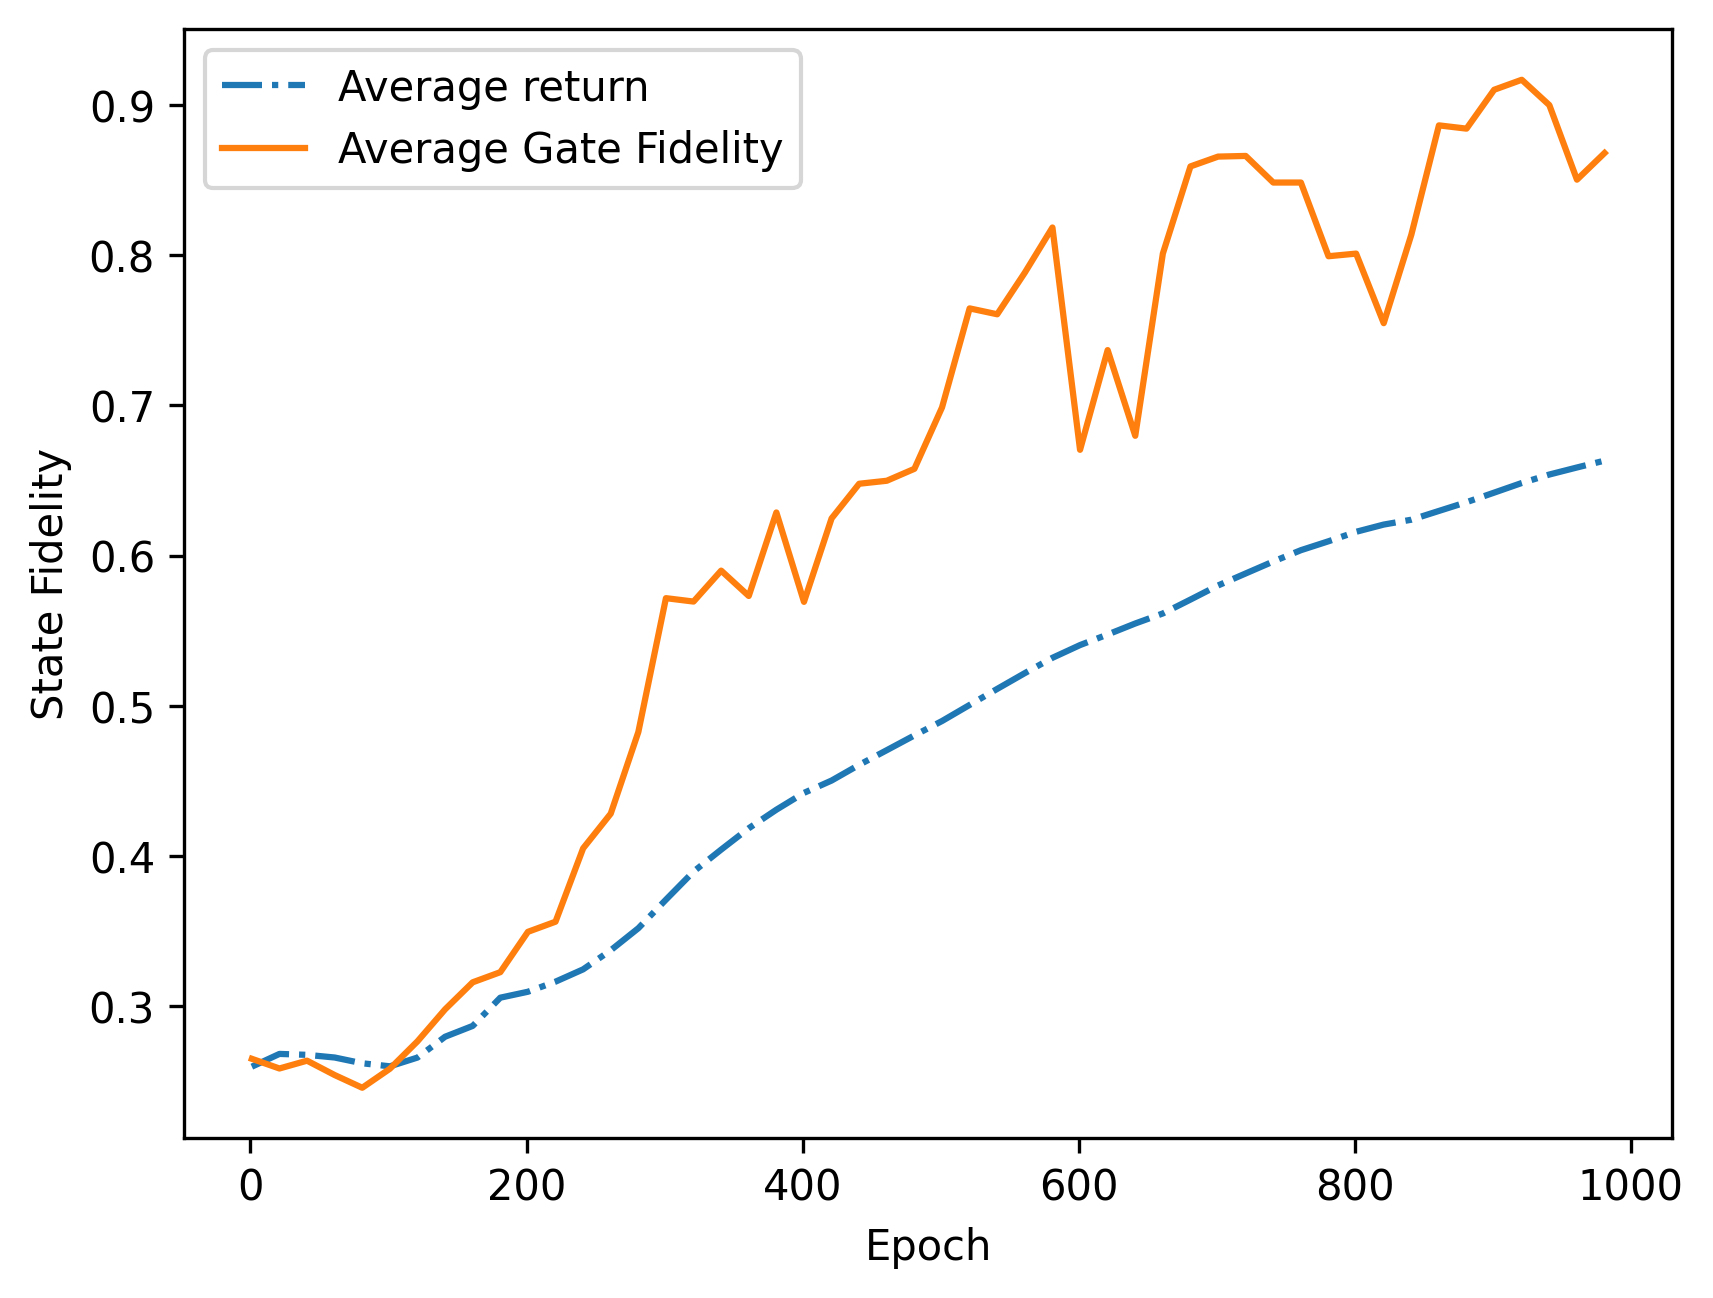

 98%|█████████▊| 981/1000 [06:47<00:07,  2.45it/s]

Maximum fidelity reached so far: 0.9273335549826629 at Epoch 910


 98%|█████████▊| 982/1000 [06:48<00:07,  2.53it/s]

Fidelity:  0.8473704361657246


 98%|█████████▊| 983/1000 [06:48<00:06,  2.63it/s]

Fidelity:  0.8420052680273001


 98%|█████████▊| 984/1000 [06:48<00:05,  2.69it/s]

Fidelity:  0.8585934603088534


 98%|█████████▊| 985/1000 [06:49<00:05,  2.75it/s]

Fidelity:  0.8571497399541742


 99%|█████████▊| 986/1000 [06:49<00:05,  2.76it/s]

Fidelity:  0.8607576112895773


 99%|█████████▊| 987/1000 [06:50<00:04,  2.78it/s]

Fidelity:  0.854517773815152


 99%|█████████▉| 988/1000 [06:50<00:04,  2.83it/s]

Fidelity:  0.8643671981676139


 99%|█████████▉| 989/1000 [06:50<00:03,  2.95it/s]

Fidelity:  0.8683378332503208


 99%|█████████▉| 990/1000 [06:51<00:03,  2.90it/s]

Fidelity:  0.8662179919967821


 99%|█████████▉| 991/1000 [06:51<00:03,  2.90it/s]

Fidelity:  0.8748491622405697


 99%|█████████▉| 992/1000 [06:51<00:02,  2.89it/s]

Fidelity:  0.8639023716761782


 99%|█████████▉| 993/1000 [06:52<00:02,  2.91it/s]

Fidelity:  0.8580038406039739


 99%|█████████▉| 994/1000 [06:52<00:02,  2.90it/s]

Fidelity:  0.8641378454737427


100%|█████████▉| 995/1000 [06:52<00:01,  2.89it/s]

Fidelity:  0.8585386984125594


100%|█████████▉| 996/1000 [06:53<00:01,  2.92it/s]

Fidelity:  0.8587409774795343


100%|█████████▉| 997/1000 [06:53<00:01,  2.87it/s]

Fidelity:  0.8472510111989779


100%|█████████▉| 998/1000 [06:53<00:00,  2.88it/s]

Fidelity:  0.8382758053704469


100%|█████████▉| 999/1000 [06:54<00:00,  2.86it/s]

Fidelity:  0.8399829277351544


100%|██████████| 1000/1000 [06:54<00:00,  2.41it/s]

Fidelity:  0.8353520199918338


In [356]:
# Initialize mu_old and sigma_old
with torch.no_grad():
    mu_old, sigma_old, _ = network(torch.Tensor(init_msmt))
    mu_old = mu_old.detach().squeeze()
    sigma_old = sigma_old.detach().squeeze()


for epoch in tqdm(range(n_epochs)):
    old_dist = MultivariateNormal(mu_old, torch.diag(sigma_old))
    
    mu, sigma, b = network(torch.Tensor(init_msmt))
    mu = mu.squeeze()
    sigma = sigma.squeeze()
    b = b.squeeze()
    policy_dist = MultivariateNormal(mu, torch.diag(sigma))

    action_vector = torch.clamp(policy_dist.sample((batchsize,)), min=-1., max=1.)
    reward = q_env.perform_action(action_vector.numpy())  # Assuming q_env can take numpy arrays

    optimizer.zero_grad()

    advantage = torch.Tensor(reward) - b

    if use_PPO:
        ratio = policy_dist.log_prob(action_vector).exp() / (old_dist.log_prob(action_vector).exp() + sigma_eps)
        actor_loss = -torch.mean(torch.min(advantage * ratio, advantage * torch.clamp(ratio, 1 - epsilon, 1 + epsilon)))
    else:
        actor_loss = -torch.mean(advantage * policy_dist.log_prob(action_vector))

    critic_loss = torch.mean(advantage ** 2)
    combined_loss = actor_loss + critic_loss_coeff * critic_loss       
    combined_loss.backward()

    torch.nn.utils.clip_grad_norm_([mu, sigma, b], grad_clip)
    
    if use_PPO:
        mu_old.data = mu.data
        sigma_old.data = sigma.data

    optimizer.step()

    # Assuming `q_env` is storing reward history and fidelity history, but this depends on your specific environment logic.
    avg_return[epoch] = np.mean(q_env.reward_history)
    # print('Average return: ', avg_return[i])
    fidelities[epoch] = np.mean(q_env.avg_fidelity_history[epoch])
    print('Fidelity: ', fidelities[epoch])

    if epoch % visualization_steps == 0:
        # Clear the current output
        from IPython.display import clear_output
        clear_output(wait=True)

        # Create the figure and plot
        fig, ax = plt.subplots()
        ax.plot(np.arange(1, n_epochs + 1, visualization_steps), avg_return[0:-1:visualization_steps], '-.', label='Average return')
        ax.plot(np.arange(1, n_epochs + 1, visualization_steps), fidelities[0:-1:visualization_steps], label='Average Gate Fidelity')
        ax.set_xlabel("Epoch")
        ax.set_ylabel("State Fidelity")
        ax.legend()
        plt.show()

        # Print additional information
        print("Maximum fidelity reached so far:", np.max(fidelities[:epoch+1]), "at Epoch", np.argmax(fidelities[:epoch+1]))

In [357]:
print("Maximum fidelity reached:", np.max(fidelities), 'at Epoch ', np.argmax(fidelities))
print("Actions yielding optimal fidelity:", np.mean(q_env.action_history[np.argmax(fidelities)], axis=0))

Maximum fidelity reached: 0.9273335549826629 at Epoch  910
Actions yielding optimal fidelity: [ 0.05662966 -0.18281026 -0.08366555 -0.24925765 -0.25036606  0.2910301
  0.24795018]
